DESARROLLO REDES NEURONALES APLICANDO A SENTIMIENTOS

---



Instalación de librerias

---



In [ ]:
!pip install transformers datasets scikit-learn torch

Carga de datos

---



In [ ]:
import pandas as pd

df = pd.read_csv("entrenamiento.csv")
df = df.dropna(subset=["comentario_s", "categoria"])
df.head()

,#,ID Programa,Programa,Tipo,Clase,Num Part,Avance,Área Académica,Clave área,Sesión,...,Dir. Programa,Matrícula,Participante,Aprendizaje 1,Aprendizaje 2,Sesión Conjunto,comentario_p,Calf. Profesor,comentario_s,categoria
0,150,1997,PSL MTY - 6,Abierto,PSL,65,100,Factor Humano,FH,PERSONALIDAD MADURA,...,CÉSAR HERNÁNDEZ CABRERA,43548,ABRAHAM MORALES MARTINEZ,"El concepto de ""madurez"" y su jerarquía de val...","Aún así me hizo reflexionar como una ""Personal...",Parece que esta vez algunos de los integrantes...,Se notó un poco sobre esforzada probablemente ...,8,En algunos moentos pareció al profesor le falt...,academia
1,416,2127,TOP TALENT PLUS ALSUPER - 1,Especial,PE,26,100,Comercialización,C,Gestión de relaciones con los clientes (CRM),...,JOSE ALEJANDRO LIMÓN GARCÍA,45074,LEONARDO MONTOYA TORRIJOS,APLICAR EN LA REALIDAD EN LA EMPRESA,BUSCAR ALTERNATIVAS,MUCHA LLUVIA DE IDEAS,MUY BIEN CANALIZADO,10,MANETER ESTE TIPO DE PROFESORES ES MUY ENRIQUE...,academia
2,399,1994,PSM MTY - 8,Abierto,PSM,42,100,Gestión de Talento,GT,Responsabilidad social 'in house': Atracción y...,...,OSCAR JAVIER VÁZQUEZ VARELA,45019,JESÚS MANUEL GONZÁLEZ JIMÉNEZ,cambio en la cultura se debe de iniciar con el...,el acceso a los puestos ejecutivos debe de est...,buena participacion de la clase,muy bien explicado y manejado,9,ninguna me gusta como el profesor lleva los casos,academia
3,577,1904,PSL TRC - 2,Abierto,PSL,21,100,Estratégia y Ejecución,EE,"FOCALIZACIÓN DE LA ESTRATEGIA, LÍNEAS DE ACCIÓ...",...,ALEJANDRO GARCÍA CERVANTES,45207,ANDRÉS HERNÁNDEZ MORTERA,Buscar la manera de compartir más con los cola...,"Revisar mis kps, de la empresa y personales",#,#,10,Traer más a este profesor,academia
4,523,1969,PSL MTY - 5,Abierto,PSL,46,100,Gestión de Talento,GT,PERSONAS CRECIMIENTOS Y RESULTADOS,...,RODRIGO GONZALEZ CABALLERO,41977,MARTIN ALMANZA RODRIGUEZ,analizando la forma en que me comporto con mis...,aprendiendo a escuchar y tener una visión dife...,nos faltó un poco de análisis,buen enfoque y aprendí algo más hoy,10,poner en mas sesiones a este tipo de profesore...,academia


Codificación de etiquetas

---



In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label"] = le.fit_transform(df["categoria"])
num_labels = len(le.classes_)

4. Tokenización con BETO

---




In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

def tokenize(batch):
    return tokenizer(batch["comentario_s"], padding="max_length", truncation=True, max_length=128)

from datasets import Dataset

dataset = Dataset.from_pandas(df[["comentario_s", "label"]])
dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("label", "labels")
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

Map:   0%|          | 0/426 [00:00<?, ? examples/s]

5. Separación en entrenamiento y validación

---




In [ ]:
dataset = dataset.train_test_split(test_size=0.2)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

6. Definición del modelo

---

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "dccuchile/bert-base-spanish-wwm-cased",
    num_labels=num_labels
)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


7.- Entrenamiento

---

In [ ]:
from transformers import EarlyStoppingCallback
from transformers import TrainingArguments, Trainer
import os
os.environ["WANDB_DISABLED"] = "true"

from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}


training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # a partir de aqui incluimos lo de early stopping
    save_strategy="epoch",
    save_total_limit=1,  # para hace mas eficiente
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # equi termine de poner los de early stopping
    per_device_train_batch_size=16, # Cambie 16 x 32 para + erficiente
    per_device_eval_batch_size=16,  # Cambie 16 x 32 para + erficiente
    num_train_epochs=8,
    fp16=True,                      # agregue esta linea para +eficiencia Si GPU compatible (como NVIDIA con CUDA),
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset, # lo siguiente es para agregar el callback
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Se detiene si no mejora en 2 épocas

)
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-1345856508.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.270700,0.952574,0.744186
2,0.608500,0.598539,0.825581
3,0.282700,0.392773,0.906977
4,0.059300,0.411424,0.872093
5,0.012600,0.398237,0.883721


TrainOutput(global_step=110, training_loss=0.5041041460904208, metrics={'train_runtime': 86.6541, 'train_samples_per_second': 31.389, 'train_steps_per_second': 2.031, 'total_flos': 111827218560000.0, 'train_loss': 0.5041041460904208, 'epoch': 5.0})

8. Evaluación y predicción

---

In [ ]:
predictions = trainer.predict(eval_dataset)
pred_labels = predictions.predictions.argmax(-1)

from sklearn.metrics import classification_report

true_labels = predictions.label_ids
print(classification_report(true_labels, pred_labels, target_names=le.classes_))

               precision    recall  f1-score   support

    CORRRECTO       0.94      0.94      0.94        17
     academia       1.00      0.77      0.87        13
    alimentos       0.89      1.00      0.94         8
       diseño       0.94      1.00      0.97        17
        grupo       0.86      0.75      0.80         8
instalaciones       0.92      0.92      0.92        13
  operaciones       0.75      0.90      0.82        10

     accuracy                           0.91        86
    macro avg       0.90      0.90      0.89        86
 weighted avg       0.91      0.91      0.91        86



In [ ]:
import torch

# Example of how to use the trained model for prediction

new_comment = "el agua mineral esta caliente"

# Tokenize the new comment
inputs = tokenizer(new_comment, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

# Move model and inputs to the same device if using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {key: val.to(device) for key, val in inputs.items()}

# Make a prediction
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(**inputs)

# Get the predicted class index
predicted_class_index = outputs.logits.argmax(-1).item()

# Decode the predicted class index back to the original label
predicted_category = le.inverse_transform([predicted_class_index])[0]

print(f"El comentario: '{new_comment}' se clasifica como: {predicted_category}")

El comentario: 'el agua mineral esta caliente' se clasifica como: alimentos


9. Visualización de perdida

---

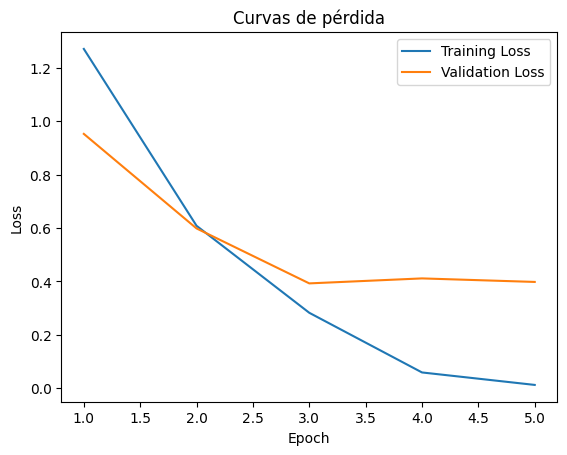

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values from trainer.state.log_history
train_loss_history = [log for log in trainer.state.log_history if 'loss' in log]
eval_loss_history = [log for log in trainer.state.log_history if 'eval_loss' in log]

# Align the training loss with the evaluation loss
train_loss_at_eval = []
eval_loss_values = []
eval_loss_epochs = []

last_train_loss = None
for log in trainer.state.log_history:
    if 'loss' in log:
        last_train_loss = log['loss']
    if 'eval_loss' in log and last_train_loss is not None:
        train_loss_at_eval.append(last_train_loss)
        eval_loss_values.append(log['eval_loss'])
        eval_loss_epochs.append(int(log['epoch'])) # Use integer epoch for plotting

# Only plot if we have data for both training and evaluation loss
if train_loss_at_eval and eval_loss_values:
    plt.plot(eval_loss_epochs, train_loss_at_eval, label='Training Loss')
    plt.plot(eval_loss_epochs, eval_loss_values, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Curvas de pérdida')
    plt.show()
else:
    print("Not enough data to plot loss curves.")

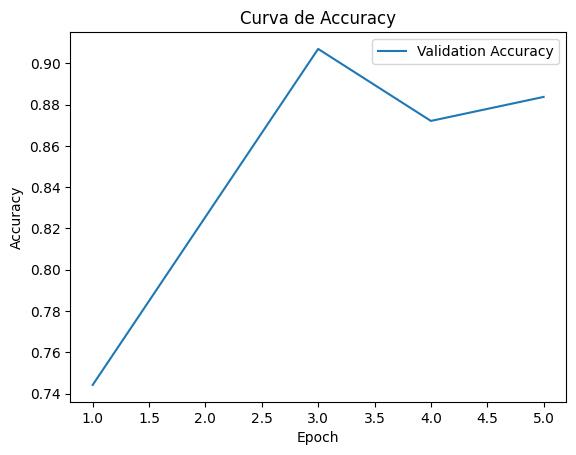

In [ ]:
import matplotlib.pyplot as plt

# Extract accuracy values from trainer.state.log_history
eval_accuracy = [log['eval_accuracy'] for log in trainer.state.log_history if 'eval_accuracy' in log]
eval_accuracy_epochs = [int(log['epoch']) for log in trainer.state.log_history if 'eval_accuracy' in log]


if eval_accuracy:
    plt.plot(eval_accuracy_epochs, eval_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Curva de Accuracy')
    plt.show()
else:
    print("Not enough data to plot accuracy curve.")

In [ ]:
import torch

print("¿CUDA disponible?:", torch.cuda.is_available())
print("Dispositivo actual:", torch.cuda.current_device())
print("Nombre del GPU:", torch.cuda.get_device_name(torch.cuda.current_device()))

¿CUDA disponible?: True
Dispositivo actual: 0
Nombre del GPU: Tesla T4
